In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

import _pickle as cPickle
# from astropy.io import ascii

In [2]:
cat = np.genfromtxt('hercXYfull.dat',names=True)

In [3]:
cat.dtype.names

('X', 'Y', 'Bmag', 'Vmag', 'RA', 'DEC')

In [4]:
xarr = cat['X']
yarr = cat['Y']
mB = cat['Bmag']
mV = cat['Vmag']

In [5]:
len(xarr[mB < 26])

16691

In [6]:
16691**(-1/3)*60

2.34777855474573

In [105]:
keep = np.logical_and(mB<26,(mB-mV)<1.2)

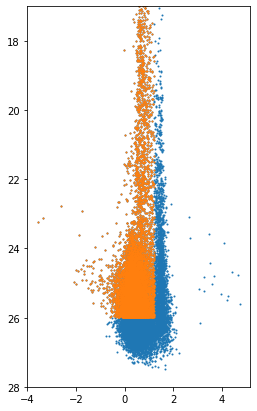

In [152]:
fig,ax = plt.subplots(figsize=(4,7))

ax.scatter(mB-mV,mB,s=1)
# ax.scatter(mB[keep2]-mV[keep2],mB[keep2],s=1)
ax.scatter(mB[keep]-mV[keep],mB[keep],s=1)

ax.set_ylim(28,17)
plt.show()

In [71]:
xgood = xarr[keep]
ygood = yarr[keep]

# xgood = xarr
# ygood = yarr

In [72]:
print(max(xgood)-min(xgood))
print(max(ygood)-min(ygood))

6533.239913237528
6943.237970139509


In [106]:
len(xgood)

14596

In [73]:
x0 = 0
y0 = 0

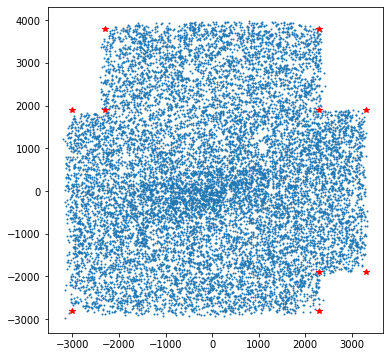

In [74]:
fig, ax = plt.subplots(figsize=(6,6))

plt.scatter(xgood,ygood,s=1)
plt.plot(-3000,1900,marker='*',color='red')
plt.plot(-2300,1900,marker='*',color='red')
plt.plot(-2300,3800,marker='*',color='red')
plt.plot(2300,3800,marker='*',color='red')
plt.plot(2300,1900,marker='*',color='red')
plt.plot(3300,1900,marker='*',color='red')
plt.plot(3300,-1900,marker='*',color='red')
plt.plot(2300,-1900,marker='*',color='red')
plt.plot(2300,-2800,marker='*',color='red')
plt.plot(-3000,-2800,marker='*',color='red')


plt.show()

In [75]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

IMAGE = Path([ [-3000,1900], 
	[-2300,1900], 
	[-2300,3800], 
	[2300,3800], 
	[2300, 1900],
    [3300, 1900],
    [3300, -1900],
    [2300, -1900],
 [2300, -2800],
 [-3000, -2800],
[-3000,1900] ])

IMG_BIT = 0b01

In [76]:
print(max(xgood))
print(min(xgood))
print(max(ygood))
print(min(ygood))

3331.0669845002494
-3202.172928737278
3969.1668121623093
-2974.0711579771996


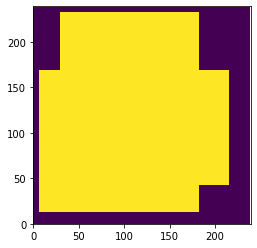

In [135]:
xmin,xmax = -3210,3990
ymin,ymax = -3210,3990

nbins = 240
xedge = np.linspace(xmin,xmax,nbins)
yedge = np.linspace(ymin,ymax,nbins)

xcent = (xedge[1:] + xedge[:-1])/2
ycent = (yedge[1:] + yedge[:-1])/2

xdel = xedge[1]-xedge[0]
ydel = yedge[1]-yedge[0]

xx,yy = np.meshgrid(xcent,ycent,indexing='ij')

MASK = np.zeros((nbins-1,nbins-1))
image_mask = IMAGE.contains_points(np.vstack([xx.flatten(),yy.flatten()]).T).T.reshape(xx.shape)
# gap_mask = GAP.contains_points(np.vstack([xx.flatten(),yy.flatten()]).T).T.reshape(xx.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
# masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
# MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
fig,ax = plt.subplots()
ax.set_xlim(0,nbins-1)
ax.set_ylim(0,nbins-1)
plt.imshow(MASK.T,origin='lower')

In [136]:
herc_x0 = 1
herc_y0 = -1

herc_nstar = 2000
herc_ext = 5.9/60 # degrees
herc_ext_pix = herc_ext*(3600/0.2255)
herc_ell = 0.5
herc_pa = -70
herc_bg = 0.1

In [137]:
herc_ext_pix

1569.8447893569846

In [138]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [139]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[xedge,yedge])
    return data_counts

In [140]:
def new_kernel(x,y,lon=herc_x0,lat=herc_y0,ext=herc_ext_pix,ell=herc_ell,pa=herc_pa):
    """ Evaluate the elliptical exponential kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e) # + background

    return pdf

In [141]:
def new_kernel_plummer(x,y,lon=herc_x0,lat=herc_y0,ext=herc_ext_pix,ell=herc_ell,pa=herc_pa):
# def new_kernel_plummer(x,y,lon=herc_x0,lat=herc_y0,ext=herc_ext_pix,pa=herc_pa):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [142]:
def model(theta_herc):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_herc[0]
#     kwargs = dict(lon=theta_herc[1],lat=theta_herc[2],ext=theta_herc[3],ell=theta_herc[4],pa=theta_herc[5])
    kwargs = dict(lon=theta_herc[1],lat=theta_herc[2],ext=theta_herc[3],ell=theta_herc[4],pa=theta_herc[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    # Default values for the other parameters
#     kwargs.update(ell=0.67)
    sigma_bg = theta_herc[6]

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel_plummer(xx,yy,**kwargs)
#     pdf = new_kernel(xx,yy,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = xdel*ydel
    model_counts = richness * pdf * pixarea + sigma_bg # converting from stars/arcmin^2 to stars/pixel^2
    return model_counts

In [143]:
def lnlike(theta, x, y):
    """ Likelihood function
    Parameters
    ----------
    theta : model parameter array (richness,lon,lat,ext,ell,pa)x2
    x: x-coordinate of data
    y: y-coordinate of data
    
    Returns
    -------
    lnlike: log-likelihood
    """

    #BREAK THETA UP INTO ERI II AND CLUSTER COMPONENTS
    #IF ONLY ONE COMPONENT IS BEING FIT, THEN THESE LINES ARE NOT NEEDED

    theta_sag = theta
    # Calculate the data counts and model predicted counts in each pixel bin
    data_counts = data(x,y)
    model_counts_sag = model(theta_sag)
    #TO FIT A SINGLE COMPONENT, USE, E.G., MODEL_COUNTS = MODEL_COUNTS_sag
#     model_counts = model_counts_sag + model_counts_cluster
    model_counts = model_counts_sag 
    
    # Apply the mask to the data and model. This selects only pixels
    # in the image for calculating the likelihood.
    data_counts_masked = data_counts[IDX]
    model_counts_masked = model_counts[IDX]
    
    # Evaluate Equation C2 from Drlica-Wagner et al. 2020 (1912.03302; ignore k! term)
    lnlike = np.sum(-model_counts_masked + data_counts_masked * np.log(model_counts_masked))
    return lnlike

In [144]:
def lnprior(theta):
    """ The log-prior. Add whatever you want here... 
    
    Parameters
    ----------
    theta : model parameters

    Returns
    -------
    lnprior : log-prior
    """
    #PRIORS FOR EACH FITTED PARAMETER

    #TO REMOVE ANY PARAMETER FROM THE FIT, REMOVE IT FROM THE LINE BELOW AND ELIMINATE THE CONSTRAINT FOR IT

#     rich1,lon1,lat1,ext1,ell1,pa1 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5]
    rich1,lon1,lat1,ext1,ell1,pa1,bg1 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6]

    if not (500 < rich1 < 30000):  return np.inf
    if not (-1000 < lon1 < 1000): return np.inf
    if not (-1000 < lat1 < 1000): return np.inf
    if not (100 < ext1 < 4000): return np.inf
    if not (0.1 <= ell1 <= 0.8): return np.inf
    if not (-120 <= pa1 <= 0): return np.inf
    if not (0 <= bg1 <= 1000): return np.inf

    return 0

In [145]:
def lnprob(theta, x, y):
    """ The log-probability = lnlike + lnprob 

    Parameters
    ----------
    theta : the model parameter vector
    x     : x-coord of the data
    y     : y-coord of the data
    
    Returns
    -------
    lnprob : log-probability
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Running mcmc...


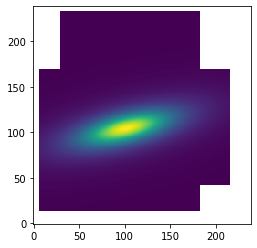

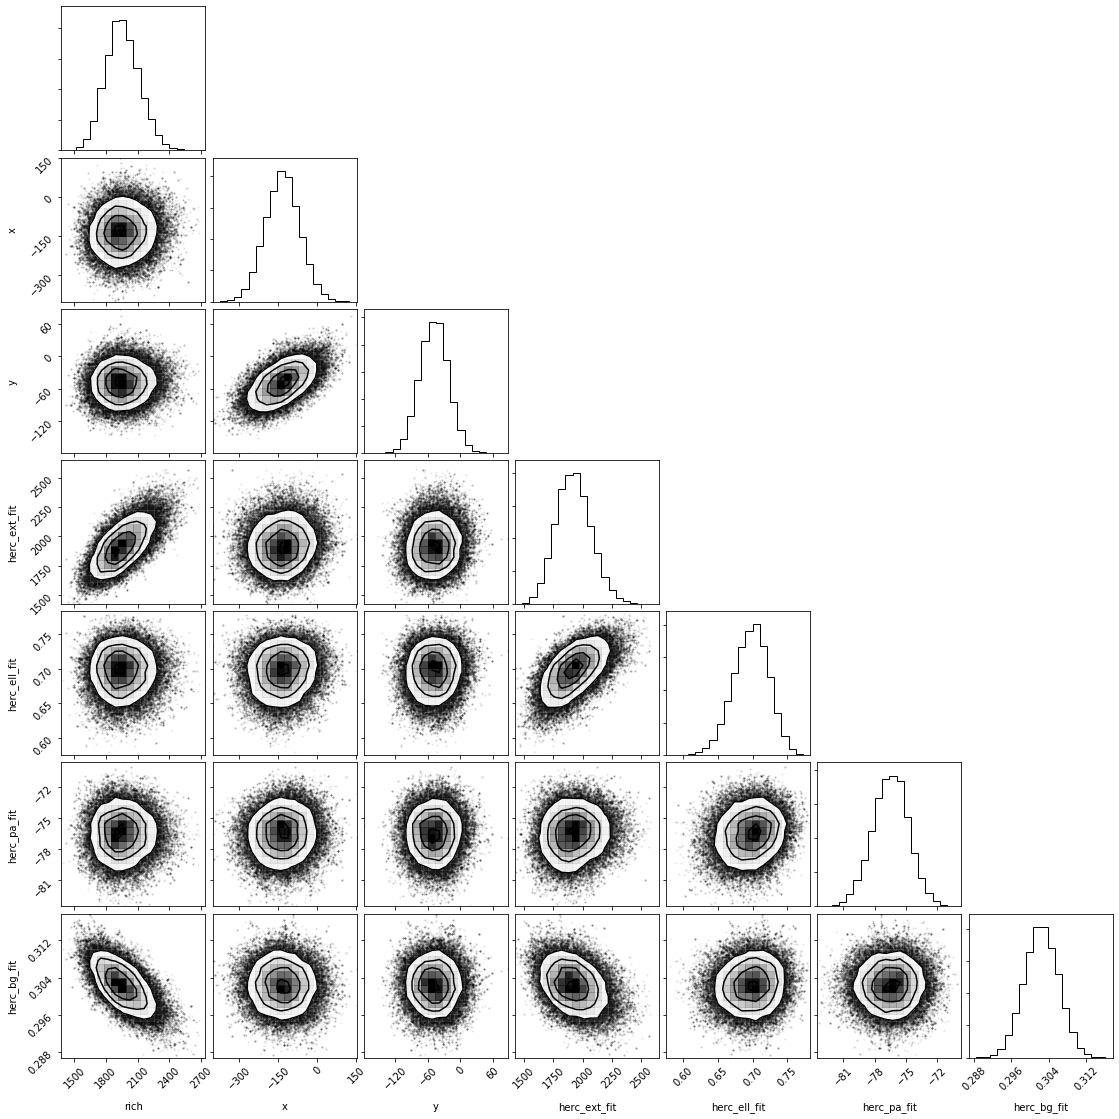

In [146]:
#FLAG FOR DISPLAYING PLOTS
do_plot=True
save_plot=True

#SET INITIAL GUESSES FOR PARAMETERS (ANY PARAMETERS NOT BEING FIT SHOULD BE REMOVED HERE)
# THETA = [herc_nstar,herc_x0,herc_y0,herc_ext_pix,herc_ell,herc_pa]
THETA = [herc_nstar,herc_x0,herc_y0,herc_ext_pix,herc_ell,herc_pa,herc_bg]

#PLOT (MASKED, BINNED) OBSERVED SURFACE DENSITY
if do_plot:
    # Example of the masked counts and data
    # (transpose due to difference between imshow and histogram2d...)
    data_counts = data(xgood,ygood)
    data_counts_masked = np.copy(data_counts)
    data_counts_masked[np.where(MASK==0)] = np.nan
    plt.imshow(data_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('data_counts_masked_hercBins240.png')

# Initialize and run the mcmc
print("Running mcmc...")
ndim, nwalkers = len(THETA), 100
nthreads,nsamples = 16, 2000
nburn = 750
pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
     
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(xgood,ygood),
                                threads=nthreads)
sampler.run_mcmc(pos,nsamples)
     
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
herc_ext_fit,[herc_ext_min,herc_ext_max] = median_interval(samples[:,3])
herc_ell_fit,[herc_ell_min,herc_ell_max] = median_interval(samples[:,4])
herc_pa_fit,[herc_pa_min,herc_pa_max] = median_interval(samples[:,5])
herc_bg_fit,[herc_bg_min,herc_bg_max] = median_interval(samples[:,6])


if do_plot:
#     theta_herc = [rich,x,y,herc_ext_fit,herc_ell_fit,herc_pa_fit]
    theta_herc = [rich,x,y,herc_ext_fit,herc_ell_fit,herc_pa_fit,herc_bg_fit]
    model_counts_herc = model(theta_herc)
    model_counts = model_counts_herc #+ model_counts_cluster
    model_counts_masked = np.copy(model_counts)
    model_counts_masked[np.where(MASK==0)] = np.nan
#PLOT (MASKED, BINNED) MODEL SURFACE DENSITY
    plt.imshow(model_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('model_counts_masked_hercBins240.png')

#CORNER PLOT    
#     fig = corner.corner(samples, labels=["rich", "x", "y", "herc_ext_fit", "herc_ell_fit", "herc_pa_fit" ])#"rich_cluster", "x_cluster", "y_cluster", "cluster_ext_fit", "cluster_ell_fit", "cluster_pa_fit"])
    fig = corner.corner(samples, labels=["rich", "x", "y", "herc_ext_fit", 
                                         "herc_ell_fit","herc_pa_fit","herc_bg_fit" ])
    if save_plot:
        fig.savefig("triangle_hercBins240.png")

# cPickle.dump(samples, open( "hercMcmcJosh.p", "wb" ) )
#1:05 AM

In [147]:
conv = 0.2255/60

In [148]:
# res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
#            herc_ext_fit,herc_ext_max-herc_ext_fit,herc_ext_fit-herc_ext_min,
#            herc_ell_fit,herc_ell_max-herc_ell_fit,herc_ell_fit-herc_ell_min,
#            herc_pa_fit,herc_pa_max-herc_pa_fit,herc_pa_fit-herc_pa_min]
# print(res)

res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
           herc_ext_fit*conv,herc_ext_max*conv-herc_ext_fit*conv,herc_ext_fit*conv-herc_ext_min*conv,
       herc_ell_fit,herc_ell_max-herc_ell_fit,herc_ell_fit-herc_ell_min,
           herc_pa_fit,herc_pa_max-herc_pa_fit,herc_pa_fit-herc_pa_min,
      herc_bg_fit,herc_bg_max-herc_bg_fit,herc_bg_fit-herc_bg_min]
print(res)

[1947.0340810061296, 166.50737921127916, 148.66656842916723, -133.8069727330452, 65.7106510545106, 67.09890450193609, -48.95955080276228, 25.92059189104852, 26.004402996487997, 7.209863656123295, 0.580269725607506, 0.5387589988882784, 0.6981724086559302, 0.024137766358684254, 0.027093359216611046, -76.47964827880365, 1.6632756265008481, 1.758115126501849, 0.302395765905183, 0.0037050951174664726, 0.0036887520555512476]
